# Infinitesimal Perturbation Analysis

In [1]:
import math

import numpy as np
import pandas as pd

from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt

from collections import deque

import time

In [2]:
def generate_service_times(x, n):
    # Exponentially distributed
    service_times = np.random.exponential(1/x, n)
    # Gamma distributed
    # service_times = np.random.gamma(x[0], x[1], n) # Mean = x[0]x[1], Variance = x[0]x[1]^2
    return service_times

In [3]:
def F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= w:
        return 1 - np.exp(-lam*np.exp(-theta_1*price)*((1-np.exp(-theta_2*w))/theta_2 + (x-w)))
    else:
        return 1 - np.exp(-lam*np.exp(-theta_1*price)*(np.exp(-theta_2*(w-x))-np.exp(-theta_2*w))/theta_2)
    
    
def inverse_F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= F(w, w, price, model_vars):
        return w - (1-np.exp(-theta_2*w))/theta_2 - np.log(1-x)*np.exp(theta_1*price)/lam
    else:
        return (1/theta_2)*np.log(1 - (theta_2/lam)*np.exp(theta_1*price+theta_2*w)*np.log(1-x))
    
    
def gradient_inverse_F(x, w, gradient_w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= F(w, w, price, model_vars):
        return (1 - np.exp(-theta_2*w))*gradient_w - (theta_1/lam)*np.exp(theta_1*price)*np.log(1-x)
    else:        
        return (theta_1 + theta_2*gradient_w)/(theta_2 - lam*np.exp(-theta_1*price-theta_2*w)/np.log(1-x))

In [4]:
def queue_simulation(n_customers, zeta, service_times, price, epsilon, model_vars):
    current_arrival_time = 0
    server_workload = 0
    
    w_plus = []
    w_minus = []
    interarrival_times = []
    
    burn_period = epsilon*n_customers
##################################################################################################################################   
    for i in range(n_customers):
        if i >= burn_period:
            w_minus.append(server_workload)
            
        server_workload += service_times[i]
        
        if i >= burn_period:
            w_plus.append(server_workload)
        
        if i != n_customers-1:
            interarrival_time = inverse_F(zeta[i], server_workload, price, model_vars)
            if i >= burn_period:
                interarrival_times.append(interarrival_time)
        
            server_workload = max(0, server_workload - interarrival_time)
            current_arrival_time += interarrival_time
    
    w_minus = np.array(w_minus)
    w_plus = np.array(w_plus)
    interarrival_times = np.array(interarrival_times)
    
    return [w_minus, w_plus, interarrival_times]

## IPA for $R(p) := \lambda p \mathbb{E}\big[H_{\theta}(p, W)\big]$

In [5]:
def revenue_gradient_estimator_1(zeta, w_minus, w_plus, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    
    n_customers = np.size(w_minus)
    
    estimator_term_1 = 0
    estimator_term_2 = np.mean(np.exp(-theta_2*w_minus))
    
    gradient_waiting_time = 0
    # Estimator term 1 calculation
    for i in range(n_customers):
        if w_minus[i] == 0:
            gradient_waiting_time = 0
        else:
            gradient_waiting_time -= gradient_inverse_F(zeta[i-1], w_plus[i-1], gradient_waiting_time, price, model_vars)
            estimator_term_1 += (1/n_customers)*(-theta_2)*np.exp(-theta_2*w_minus[i])*gradient_waiting_time
    
    revenue_grad_est = lam*price*np.exp(-theta_1*price)*estimator_term_1 + lam*(1-theta_1*price)*np.exp(-theta_1*price)*estimator_term_2
        
    return revenue_grad_est

In [6]:
def implement_IPA_1(n_iters, initial_n_customers, initial_price, model_vars):
    
    price = initial_price
    price_iterates = [initial_price]
    
    for i in range(1, n_iters+1):
        n_customers = (int)(initial_n_customers * math.sqrt(i))
        
        service_times = generate_service_times(1, n_customers)
        zeta = np.random.random(n_customers-1)
        
        # epsilon = np.random.random()
        epsilon = 0
        
        [w_minus, w_plus, interarrival_times] = queue_simulation(n_customers, zeta, service_times, price, epsilon, model_vars)
        
        revenue_grad_est = revenue_gradient_estimator_1(zeta, w_minus, w_plus, price, model_vars)
        
        learning_rate = 20/np.power(i, 1)
        price = price + learning_rate*revenue_grad_est
        
        price_iterates.append(price)
        
        # print(i)
    
    return price_iterates

In [7]:
# Simulation

n_iters = 100
N_0 = 1000
initial_price = 50
model_vars = [20, 0.1, 0.2]

price_iterates = implement_IPA_1(n_iters, N_0, initial_price, model_vars)

Text(0.5, 1.0, 'IPA gradient estimator for price convergence')

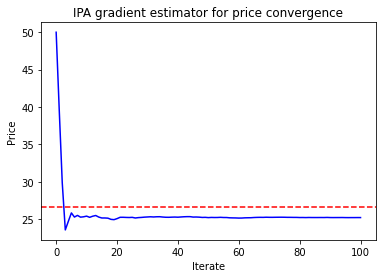

In [8]:
## Plots

optimal_price = 26.6

plt.plot(price_iterates, color = "blue")
plt.axhline(optimal_price, color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Price")
plt.title("IPA gradient estimator for price convergence")

## Evaluating $p^*$ via simulation

In [ ]:
def simulated_average_revenue(n_customers, price, arrival_times, service_times, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    
    server_workload = 0
    total_collections = 0
##################################################################################################################################   
    for i in range(n_customers):
        
        joining_prob = np.exp(-theta_1*price-theta_2*server_workload)
        joining_decision = np.random.binomial(1, joining_prob)
        
        if joining_decision == 1:
            total_collections += price
            
        if i != n_customers-1:
            server_workload = max(0, server_workload + service_times[i]*joining_decision - (arrival_times[i+1]-arrival_times[i]))
    
    average_revenue_per_unit_time = total_collections/arrival_times[-1]
    
    return average_revenue_per_unit_time

In [ ]:
# Check optimal price via simulation

model_vars = [10, 0.1, 0.2]

prices = np.linspace(20.1, 22, 20)
simulated_revenues = []

for p in prices:
    
    n_iter = 100
    n_customers = 100000
    
    average_average_revenue = 0
    
    for i in range(n_iter):
        
        interarrival_times = np.random.exponential(1/model_vars[0], n_customers)
        arrival_times = np.cumsum(interarrival_times)
        
        service_times = np.random.exponential(1, n_customers)
        
        average_average_revenue += (1/n_iter)*simulated_average_revenue(n_customers, p, arrival_times, service_times, model_vars)
    
    print(p)
    
    simulated_revenues.append(average_average_revenue)

In [ ]:
optimal_price = 0
optimal_revenue = 0

for i in range(len(prices)):
    if simulated_revenues[i] > optimal_revenue:
        optimal_price = prices[i]
        optimal_revenue = simulated_revenues[i]

print(optimal_price)

In [ ]:
plt.plot(prices, simulated_revenues, color="red")
plt.axyline(optimal_price, color="blue", "dashed")
plt.xlabel("p")
plt.ylabel("R(p)")
plt.title("Average revenue per unit time vs price")
plt.savefig("Revenue_versus_price.pdf")

## Checks

In [ ]:
## Checking inverse F function

w = 0

zetas = np.random.random(100)
interarrival_times = []

for zeta in zetas:
    interarrival_times.append(inverse_F(zeta, w, 0, [10, 0.1, 0.2]))
    
interarrival_times = np.array(interarrival_times)

print(interarrival_times.mean())
print(interarrival_times.var())

In [ ]:
# Service occupation fraction calculation

n_customers = 100000

zeta = np.random.random(n_customers-1)
service_times = generate_service_times(1, n_customers)

price = 25

model_vars = [20, 0.1, 0.2]

x = queue_simulation(n_customers, zeta, service_times, price, model_vars)

In [ ]:
## For optimal price, run IPA estimator for derivative R(p)

model_vars = [20, 0.1, 0.2]
n_customers = 10000
epsilon = 0.1

n_iters = 100

prices = np.linspace(25.1, 30, 50)
average_gradient_revenues = []

for price in prices:
    
    average_grad_revenue_given_price = 0
    
    for i in range(n_iters):
        
        service_times = generate_service_times(1, n_customers)
        zeta = np.random.random(n_customers-1)

        [w_minus, w_plus] = queue_simulation(n_customers, zeta, service_times, price, epsilon, model_vars)

        average_grad_revenue_given_price += (1/n_iters)*revenue_gradient_estimator(zeta, w_minus, w_plus, price, model_vars)
        
    average_gradient_revenues.append(average_grad_revenue_given_price)

In [ ]:
plt.plot(prices, average_gradient_revenues, color = "blue")
plt.xlabel("Price")
plt.ylabel("Gradient of R(p)")
plt.title("Simulated gradient of R(p) for various prices.")